# Multiclass Fish Image Classification (Colab-ready)
**Generated:** Use in Colab.

This notebook mounts Google Drive, trains multiple image classification models (CNN scratch, VGG16, ResNet50, MobileNetV2, EfficientNetB0), evaluates them, and includes optional Streamlit deployment instructions.

⚠️ **Before running:** Upload your dataset to Google Drive at `MyDrive/data` OR update `DATA_DIR` below to your path. Expected structure:


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#!unzip -d /content/drive/MyDrive/data /content/drive/MyDrive/data.zip

# Change this if your data is in a different Drive path
DATA_DIR = "/content/drive/MyDrive/data/data"

# Check GPU
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
device_name = tf.test.gpu_device_name()
print('GPU device:', device_name if device_name else 'No GPU detected. Go to Runtime -> Change runtime type -> GPU')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.19.0
GPU device: /device:GPU:0


In [ ]:
import shutil, os

src = "/content/drive/MyDrive/data"
dst = "/content/data"

if not os.path.exists(dst):
    print("📦 Copying dataset from Drive to Colab (only first time, faster training)...")
    shutil.copytree(src, dst)
else:
    print("✅ Dataset already available locally!")

# Update your base data path
DATA_DIR = "/content/data/data"
print("Using local dataset path:", DATA_DIR)


✅ Dataset already available locally!
Using local dataset path: /content/data/data


In [ ]:
# Optional installs (may be fast or already present)
!pip install -q efficientnet tfds-nightly tensorflow-addons pyngrok streamlit >/dev/null 2>&1 || true
print('Install step completed (some packages may have been already present).')


Install step completed (some packages may have been already present).


Data generator utilities

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generators(train_dir, val_dir, test_dir=None, img_size=(224,224), batch_size=64):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        #brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_gen = None
    if test_dir and os.path.exists(test_dir):
        test_gen = val_datagen.flow_from_directory(
            test_dir,
            target_size=img_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )

    return train_gen, val_gen, test_gen

print('Data generator utilities defined.')


Data generator utilities defined.


Model builders

In [ ]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model

def build_scratch_cnn(input_shape=(224,224,3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs, name='scratch_cnn')

def build_transfer_model(base_name, input_shape=(224,224,3), num_classes=10, trainable_top=10):
    weights = 'imagenet'
    if base_name == 'VGG16':
        base = VGG16(include_top=False, input_shape=input_shape, weights=weights)
    elif base_name == 'ResNet50':
        base = ResNet50(include_top=False, input_shape=input_shape, weights=weights)
    elif base_name == 'MobileNetV2':
        base = MobileNetV2(include_top=False, input_shape=input_shape, weights=weights)
    elif base_name == 'EfficientNetB0':
        base = EfficientNetB0(include_top=False, input_shape=input_shape, weights=weights)
    else:
        raise ValueError('Unknown base model')

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=outputs, name=f'{base_name}_transfer')

    for layer in base.layers:
        layer.trainable = False

    if trainable_top > 0:
        for layer in base.layers[-trainable_top:]:
            layer.trainable = True

    return model

print('Model builders ready.')


Model builders ready.


Training helper

In [ ]:
import time
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
RESULTS = {}

def compile_and_train(model, train_gen, val_gen, output_dir, epochs=10, lr=1e-4):
    os.makedirs(output_dir, exist_ok=True)
    model.compile(optimizer=optimizers.Adam(lr), loss=CategoricalCrossentropy(), metrics=['accuracy'])
    ckpt = ModelCheckpoint(os.path.join(output_dir, model.name + '_best.h5'), monitor='val_accuracy', save_best_only=True)
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    t0 = time.time()
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[ckpt, rl, es])
    t1 = time.time()
    elapsed = (t1 - t0) / 60.0
    print(f'Training {model.name} took {elapsed:.2f} minutes')

    model.save(os.path.join(output_dir, model.name + '_final.h5'))
    return history, elapsed

print('Training helper defined.')


Training helper defined.


Full run: create generators and train selected models

In [ ]:
# USER CONFIG
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')  # optional
IMG_SIZE = (224,224)
BATCH_SIZE = 64
EPOCHS = 10  # set to 5 for a quick smoke test, 15-30 for real training
OUTPUT_DIR = '/content/outputs'

# Create generators
train_gen, val_gen, test_gen = create_generators(TRAIN_DIR, VAL_DIR, TEST_DIR, img_size=IMG_SIZE, batch_size=BATCH_SIZE)

"""from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights automatically
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)"""
num_classes = train_gen.num_classes
print('Classes:', train_gen.class_indices)


# Models to train
model_names = ['scratch', 'VGG16', 'ResNet50', 'MobileNetV2', 'EfficientNetB0']
for name in model_names:
    print('\n' + '='*40)
    print('Preparing model:', name)
    if name == 'scratch':
        model = build_scratch_cnn(input_shape=IMG_SIZE + (3,), num_classes=num_classes)
    else:
        model = build_transfer_model(name, input_shape=IMG_SIZE + (3,), num_classes=num_classes, trainable_top=50)

    history, elapsed = compile_and_train(model, train_gen, val_gen, OUTPUT_DIR, epochs=EPOCHS, lr=1e-4)
    best_val_acc = max(history.history.get('val_accuracy', [0]))
    RESULTS[model.name] = {'time_min': elapsed, 'best_val_acc': float(best_val_acc)}

print('\nAll runs completed. Summary:')
print(RESULTS)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
Classes: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}

Preparing model: scratch
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.1546 - loss: 2.3636

98/98 ━━━━━━━━━━━━━━━━━━━━ 95s 878ms/step - accuracy: 0.1547 - loss: 2.3633 - val_accuracy: 0.1712 - val_loss: 2.3021 - learning_rate: 1.0000e-04
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 825ms/step - accuracy: 0.1685 - loss: 2.2919 - val_accuracy: 0.1712 - val_loss: 2.2467 - learning_rate: 1.0000e-04
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.1881 - loss: 2.2025

98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 819ms/step - accuracy: 0.1881 - loss: 2.2021 - val_accuracy: 0.2903 - val_loss: 2.0544 - learning_rate: 1.0000e-04
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.2799 - loss: 2.0137

98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 819ms/step - accuracy: 0.2801 - loss: 2.0132 - val_accuracy: 0.3049 - val_loss: 1.8953 - learning_rate: 1.0000e-04
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.3370 - loss: 1.8455

98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 814ms/step - accuracy: 0.3370 - loss: 1.8453 - val_accuracy: 0.3901 - val_loss: 1.7667 - learning_rate: 1.0000e-04
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.3561 - loss: 1.7728

98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 815ms/step - accuracy: 0.3562 - loss: 1.7726 - val_accuracy: 0.4341 - val_loss: 1.6825 - learning_rate: 1.0000e-04
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 820ms/step - accuracy: 0.3887 - loss: 1.7231 - val_accuracy: 0.4011 - val_loss: 1.6543 - learning_rate: 1.0000e-04
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.4006 - loss: 1.6573

98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 819ms/step - accuracy: 0.4007 - loss: 1.6572 - val_accuracy: 0.4597 - val_loss: 1.5758 - learning_rate: 1.0000e-04
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.4344 - loss: 1.5903

98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 816ms/step - accuracy: 0.4343 - loss: 1.5904 - val_accuracy: 0.4625 - val_loss: 1.5272 - learning_rate: 1.0000e-04
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.4527 - loss: 1.5812

98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 820ms/step - accuracy: 0.4527 - loss: 1.5809 - val_accuracy: 0.4716 - val_loss: 1.5124 - learning_rate: 1.0000e-04


Training scratch_cnn took 13.66 minutes

Preparing model: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2126 - loss: 2.2256

98/98 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.2137 - loss: 2.2224 - val_accuracy: 0.7326 - val_loss: 0.7671 - learning_rate: 1.0000e-04
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7363 - loss: 0.7742

98/98 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7371 - loss: 0.7722 - val_accuracy: 0.9588 - val_loss: 0.1421 - learning_rate: 1.0000e-04
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9397 - loss: 0.1942 - val_accuracy: 0.9020 - val_loss: 0.2901 - learning_rate: 1.0000e-04
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9583 - loss: 0.1510

98/98 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9585 - loss: 0.1504 - val_accuracy: 0.9863 - val_loss: 0.0480 - learning_rate: 1.0000e-04
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9878 - loss: 0.0403

98/98 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9878 - loss: 0.0403 - val_accuracy: 0.9881 - val_loss: 0.0345 - learning_rate: 1.0000e-04
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9897 - loss: 0.0401 - val_accuracy: 0.9808 - val_loss: 0.0630 - learning_rate: 1.0000e-04
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9827 - loss: 0.0618 - val_accuracy: 0.9734 - val_loss: 0.0759 - learning_rate: 1.0000e-04
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9827 - loss: 0.0599
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
98/98 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9827 - loss: 0.0599 - val_accuracy: 0.9872 - val_loss: 0.0447 - learning_rate: 1.0000e-04
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9915 - loss: 0.0391

98/98 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9915 - loss: 0.0390 - val_accuracy: 0.9908 - val_loss: 0.0256 - learning_rate: 5.0000e-05
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9936 - loss: 0.0158

98/98 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9936 - loss: 0.0158 - val_accuracy: 0.9936 - val_loss: 0.0202 - learning_rate: 5.0000e-05


Training VGG16_transfer took 21.16 minutes

Preparing model: ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.3036 - loss: 1.9791

98/98 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.3045 - loss: 1.9767 - val_accuracy: 0.1273 - val_loss: 3.6828 - learning_rate: 1.0000e-04
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.5058 - loss: 1.3661

98/98 ━━━━━━━━━━━━━━━━━━━━ 87s 886ms/step - accuracy: 0.5060 - loss: 1.3658 - val_accuracy: 0.2299 - val_loss: 8.3071 - learning_rate: 1.0000e-04
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.5781 - loss: 1.2057

98/98 ━━━━━━━━━━━━━━━━━━━━ 89s 905ms/step - accuracy: 0.5782 - loss: 1.2053 - val_accuracy: 0.2610 - val_loss: 3.1908 - learning_rate: 1.0000e-04
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.6160 - loss: 1.0955

98/98 ━━━━━━━━━━━━━━━━━━━━ 88s 894ms/step - accuracy: 0.6161 - loss: 1.0953 - val_accuracy: 0.3407 - val_loss: 3.0946 - learning_rate: 1.0000e-04
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 88s 895ms/step - accuracy: 0.6579 - loss: 0.9955 - val_accuracy: 0.3049 - val_loss: 4.2032 - learning_rate: 1.0000e-04
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 881ms/step - accuracy: 0.7071 - loss: 0.8558 - val_accuracy: 0.2408 - val_loss: 3.5462 - learning_rate: 1.0000e-04
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.7153 - loss: 0.8368

98/98 ━━━━━━━━━━━━━━━━━━━━ 88s 896ms/step - accuracy: 0.7154 - loss: 0.8364 - val_accuracy: 0.5174 - val_loss: 1.5188 - learning_rate: 1.0000e-04
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.7297 - loss: 0.7806

98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 869ms/step - accuracy: 0.7299 - loss: 0.7801 - val_accuracy: 0.5714 - val_loss: 1.6830 - learning_rate: 1.0000e-04
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 87s 888ms/step - accuracy: 0.7648 - loss: 0.6714 - val_accuracy: 0.5284 - val_loss: 2.0022 - learning_rate: 1.0000e-04
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.7889 - loss: 0.6096
Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 876ms/step - accuracy: 0.7889 - loss: 0.6097 - val_accuracy: 0.3810 - val_loss: 3.8899 - learning_rate: 1.0000e-04


Training ResNet50_transfer took 15.40 minutes

Preparing model: MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.6324 - loss: 1.2295

98/98 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6345 - loss: 1.2229 - val_accuracy: 0.7216 - val_loss: 0.8574 - learning_rate: 1.0000e-04
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.9897 - loss: 0.0585

98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 820ms/step - accuracy: 0.9897 - loss: 0.0584 - val_accuracy: 0.7940 - val_loss: 0.6166 - learning_rate: 1.0000e-04
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.9939 - loss: 0.0264

98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 817ms/step - accuracy: 0.9939 - loss: 0.0264 - val_accuracy: 0.8068 - val_loss: 0.5761 - learning_rate: 1.0000e-04
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.9986 - loss: 0.0117

98/98 ━━━━━━━━━━━━━━━━━━━━ 79s 804ms/step - accuracy: 0.9986 - loss: 0.0117 - val_accuracy: 0.9029 - val_loss: 0.3301 - learning_rate: 1.0000e-04
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.9967 - loss: 0.0122

98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 820ms/step - accuracy: 0.9967 - loss: 0.0122 - val_accuracy: 0.9597 - val_loss: 0.1369 - learning_rate: 1.0000e-04
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.9982 - loss: 0.0046

98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 818ms/step - accuracy: 0.9982 - loss: 0.0046 - val_accuracy: 0.9689 - val_loss: 0.1089 - learning_rate: 1.0000e-04
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 815ms/step - accuracy: 0.9982 - loss: 0.0049 - val_accuracy: 0.9643 - val_loss: 0.1074 - learning_rate: 1.0000e-04
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 79s 806ms/step - accuracy: 0.9996 - loss: 0.0027 - val_accuracy: 0.9689 - val_loss: 0.0898 - learning_rate: 1.0000e-04
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.9993 - loss: 0.0032

98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 841ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9863 - val_loss: 0.0489 - learning_rate: 1.0000e-04
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 819ms/step - accuracy: 0.9976 - loss: 0.0077 - val_accuracy: 0.9780 - val_loss: 0.0799 - learning_rate: 1.0000e-04


Training MobileNetV2_transfer took 14.53 minutes

Preparing model: EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.1333 - loss: 2.3789

98/98 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.1334 - loss: 2.3787 - val_accuracy: 0.0916 - val_loss: 2.4269 - learning_rate: 1.0000e-04
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.1622 - loss: 2.3305

98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 833ms/step - accuracy: 0.1622 - loss: 2.3303 - val_accuracy: 0.1712 - val_loss: 2.3334 - learning_rate: 1.0000e-04
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 833ms/step - accuracy: 0.1830 - loss: 2.2858 - val_accuracy: 0.1712 - val_loss: 2.3266 - learning_rate: 1.0000e-04
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 79s 810ms/step - accuracy: 0.2012 - loss: 2.2137 - val_accuracy: 0.1712 - val_loss: 2.8514 - learning_rate: 1.0000e-04
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 832ms/step - accuracy: 0.2019 - loss: 2.1694 - val_accuracy: 0.1712 - val_loss: 2.4227 - learning_rate: 1.0000e-04
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.2212 - loss: 2.1395
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 828ms/step - accuracy: 0.2213 - loss: 2.1394 - val_accuracy: 0.1712 - val_loss: 5.8172 - learning_rate: 1.0000e-04
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 828ms/step - accuracy: 0.2524 - l

98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 833ms/step - accuracy: 0.2525 - loss: 2.0404 - val_accuracy: 0.2454 - val_loss: 2.0569 - learning_rate: 5.0000e-05
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 834ms/step - accuracy: 0.2684 - loss: 2.0306 - val_accuracy: 0.1703 - val_loss: 2.3133 - learning_rate: 5.0000e-05
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 820ms/step - accuracy: 0.2584 - loss: 2.0187 - val_accuracy: 0.1712 - val_loss: 4.7819 - learning_rate: 5.0000e-05


Training EfficientNetB0_transfer took 14.78 minutes

All runs completed. Summary:
{'scratch_cnn': {'time_min': 13.65578370889028, 'best_val_acc': 0.47161170840263367}, 'VGG16_transfer': {'time_min': 21.161500024795533, 'best_val_acc': 0.9935897588729858}, 'ResNet50_transfer': {'time_min': 15.404762796560924, 'best_val_acc': 0.5714285969734192}, 'MobileNetV2_transfer': {'time_min': 14.527649780114492, 'best_val_acc': 0.9862637519836426}, 'EfficientNetB0_transfer': {'time_min': 14.77710090080897, 'best_val_acc': 0.24542124569416046}}


Evaluation: classification report & confusion matrix

Found best models: ['/content/outputs/EfficientNetB0_transfer_best.h5', '/content/outputs/VGG16_transfer_best.h5', '/content/outputs/MobileNetV2_transfer_best.h5', '/content/outputs/scratch_cnn_best.h5', '/content/outputs/ResNet50_transfer_best.h5']


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step
                                  precision    recall  f1-score   support

                     animal fish       0.97      0.99      0.98       187
                animal fish bass       0.83      0.50      0.62        10
   fish sea_food black_sea_sprat       1.00      1.00      1.00       105
   fish sea_food gilt_head_bream       1.00      1.00      1.00        94
   fish sea_food hourse_mackerel       1.00      1.00      1.00        97
        fish sea_food red_mullet       1.00      1.00      1.00        90
     fish sea_food red_sea_bream       1.00      1.00      1.00       113
          fish sea_food sea_bass       1.00      1.00      1.00        97
            fish sea_food shrimp       0.99      1.00      1.00       100
fish sea_food striped_red_mullet       1.00      1.00      1.00       101
             fish sea_food trout       1.00      1.00      1.00        98

                        accuracy                           0.99      

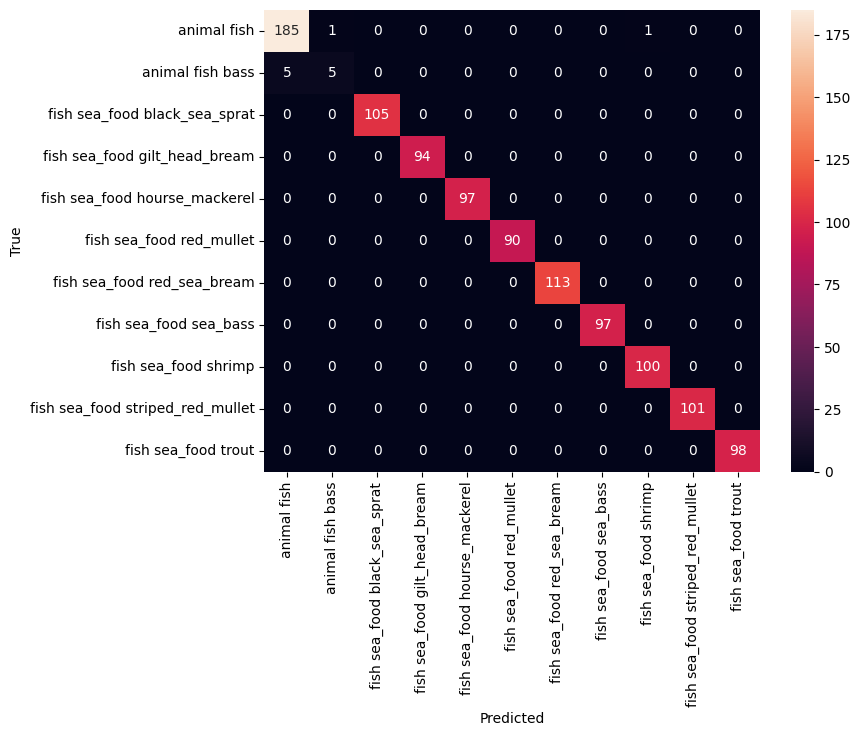

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_model(model_path, gen):
    from tensorflow.keras.models import load_model
    model = load_model(model_path)
    preds = model.predict(gen, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = gen.classes
    labels = list(gen.class_indices.keys())
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

# Example: evaluate the saved best model for EfficientNetB0 if present
import glob
best_models = glob.glob('/content/outputs/*_best.h5')
print('Found best models:', best_models)
if best_models:
    evaluate_model(best_models[1], val_gen)
else:
    print('No best models found. Run the training cell first.')


Comparison plots

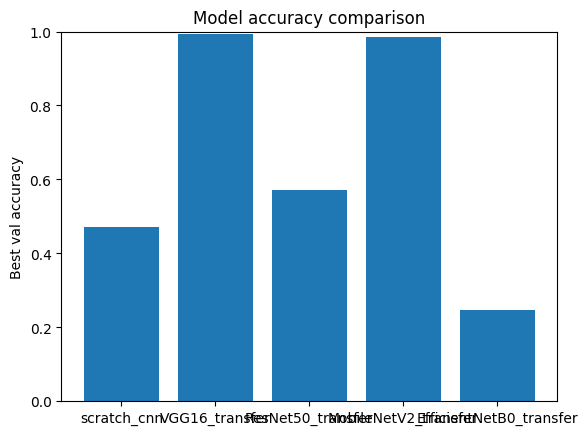

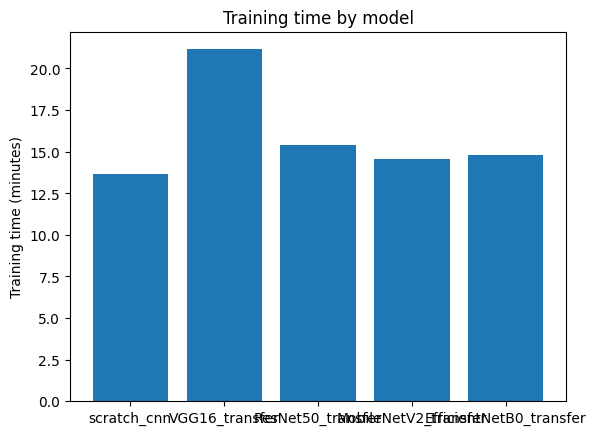

In [ ]:
# Plot RESULTS summary if available
if RESULTS:
    import matplotlib.pyplot as plt
    names = list(RESULTS.keys())
    times = [RESULTS[n]['time_min'] for n in names]
    accs = [RESULTS[n]['best_val_acc'] for n in names]

    fig, ax1 = plt.subplots()
    ax1.bar(names, accs)
    ax1.set_ylabel('Best val accuracy')
    ax1.set_ylim(0,1)
    ax1.set_title('Model accuracy comparison')
    plt.show()

    fig, ax2 = plt.subplots()
    ax2.bar(names, times)
    ax2.set_ylabel('Training time (minutes)')
    ax2.set_title('Training time by model')
    plt.show()
else:
    print('No RESULTS available. Run training first.')


In [ ]:
# --- Install everything ---
!pip install -q streamlit pyngrok

import os, time, subprocess
from pyngrok import ngrok

# --- Step 1: Ensure app is in /content/app ---
os.makedirs("/content/app", exist_ok=True)
if not os.path.exists("/content/app/streamlit_app.py"):
    # Copy from Drive if it exists there
    if os.path.exists("/content/drive/MyDrive/app/streamlit_app.py"):
        !cp /content/drive/MyDrive/app/streamlit_app.py /content/app/
        print("✅ Copied app from Drive to /content/app/")
    else:
        raise FileNotFoundError("streamlit_app.py not found in Drive or /content/app")

# --- Step 2: Kill any old servers ---
!pkill streamlit || echo "No existing Streamlit instance"
!pkill ngrok || echo "No existing ngrok tunnel"

# --- Step 3: Start Streamlit in background ---
print("🚀 Starting Streamlit server...")
process = subprocess.Popen(
    ["streamlit", "run", "/content/app/streamlit_app.py", "--server.port", "8501"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Wait for Streamlit to initialize
time.sleep(10)

# --- Step 4: Open ngrok tunnel ---
!ngrok config add-authtoken 355o6FF4XyhTPlN7QcEhY06OZg7_6w56Vh6xAGPdLcRTckXgQ
public_url = ngrok.connect(8501)
print("✅ Streamlit Public URL:", public_url)
print("🌐 Open this link in a new browser tab (wait ~5 sec if blank initially).")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.5 MB/s eta 0:00:00
No existing Streamlit instance
No existing ngrok tunnel
🚀 Starting Streamlit server...
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
✅ Streamlit Public URL: NgrokTunnel: "https://unluxuriously-unsevered-lisabeth.ngrok-free.dev" -> "http://localhost:8501"
🌐 Open this link in a new browser tab (wait ~5 sec if blank initially).


Quick Prediction

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose an image file (.jpg, .png)


Saving bs_fish.jpg to bs_fish.jpg


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Path to your best model
model_path = "/content/outputs/VGG16_transfer_best.h5"

# Load model
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")

# Get class labels from your generator (you can reuse train_gen)
labels = list(train_gen.class_indices.keys())
print("Labels:", labels)

# Load uploaded image
img_path = list(uploaded.keys())[0]
img = Image.open(img_path).convert('RGB')
img = img.resize((224,224))
img_arr = np.array(img) / 255.0
img_arr = np.expand_dims(img_arr, axis=0)

# Predict
preds = model.predict(img_arr)
pred_idx = np.argmax(preds)
confidence = np.max(preds)

print(f"Predicted Class: {labels[pred_idx]}")
print(f"Confidence: {confidence:.2f}")


Model loaded successfully!
Labels: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: animal fish
Confidence: 1.00
